# **Adversarial Attacks on Graph-Based Bot Detection – Baseline**

This notebook builds a **baseline bot detection model** using the  
Twitter Bot Detection dataset from Kaggle:  
https://www.kaggle.com/datasets/goyaladi/twitter-bot-detection-dataset

Because the dataset does **not** contain real `@mentions` or real hashtag tokens, we cannot build a true interaction graph.  
Instead, we construct a **keyword-based proxy graph** from the `Hashtags` field and compute **graph-inspired features** from keyword statistics.

### ✔ Dataset Components
- User profile information (followers, verified, location)
- Tweet content
- A synthetic “Hashtags” column that contains keyword phrases
- Binary bot label (0 = human, 1 = bot)

### ✔ Features Used
We extract a combination of:
- **Profile features**  
  (`Follower Count`, `Retweet Count`, `Mention Count`, `Verified`)
- **Keyword-based graph-inspired features**  
  (`num_keywords`, `avg_kw_pop`, `sum_kw_pop`, `prop_rare_kw`, `kw_entropy`, etc.)

These proxy features approximate structural graph behavior without needing a full Twitter interaction network.

### ✔ Baseline Classifier
We train a **Random Forest** classifier to distinguish bots from humans using the combined profile + keyword features.

---

Later in the notebook, we apply two adversarial strategies:

### **1. Structural Evasion Attack (Test-Time Attack)**  
Modify bot features to look more human → decreases detection recall.

### **2. Graph Poisoning Attack (Training-Time Attack)**  
Flip labels of training bots or alter their features → corrupt model training → severe performance drop.

We then **compare performance before and after both attacks** to evaluate model robustness.


## **Imports**

In [1]:
import os
import re
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


## **1. Load the Dataset**

We load the Twitter Bot Detection dataset from the local directory.  
The dataset contains 50,000 rows and includes:

- User profile information  
- Tweet text  
- Engagement statistics  
- A synthetic “Hashtags” field used later to extract keyword-based features  
- A binary `Bot Label` (0 = human, 1 = bot)

We begin by reading the CSV file and inspecting its structure.


In [2]:
data_path = r"E:\OMAR IBRAHIM\SEMESTER 7\SOCIAL NET COMPUTING\SECTIONS\FINAL PROJECT\bot_detection_data.csv"

df = pd.read_csv(data_path, encoding="utf-8", low_memory=False)

print("Shape:", df.shape)
df.head(5)

Shape: (50000, 11)


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


## **2. Inspect the Dataset**

Before preprocessing, we inspect the structure of the dataframe to understand:

- Column names  
- Data types  
- Missing or null values  
- Overall dataset size  

This step helps identify which fields require cleaning, encoding, or feature extraction later.


In [3]:

print("Columns:\n", df.columns.tolist(), "\n")

df.info()


Columns:
 ['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At', 'Hashtags'] 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   User ID         50000 non-null  int64 
 1   Username        50000 non-null  object
 2   Tweet           50000 non-null  object
 3   Retweet Count   50000 non-null  int64 
 4   Mention Count   50000 non-null  int64 
 5   Follower Count  50000 non-null  int64 
 6   Verified        50000 non-null  bool  
 7   Bot Label       50000 non-null  int64 
 8   Location        50000 non-null  object
 9   Created At      50000 non-null  object
 10  Hashtags        41659 non-null  object
dtypes: bool(1), int64(5), object(5)
memory usage: 3.9+ MB


## **3. Basic Cleaning and User-Level Aggregation**

The dataset is originally at the **tweet level**, meaning each row corresponds to a single tweet posted by a user.  
Since our goal is to build a **user-level bot detection model**, we must convert the dataset so that:

- **One row = one user**
- All tweet-level information for a user is aggregated into meaningful user-level features

### In this step, we will:
1. Clean column names (remove trailing spaces)
2. Ensure essential columns such as `Username` and `Bot Label` are valid
3. Prepare the dataframe for grouping by `Username`

This prepares the data for computing aggregated features such as average retweet count, total mentions, or keyword statistics per user.


## **3.1 Clean column names**

Sometimes CSV files include spaces, so we strip whitespace.


In [4]:
df.columns = df.columns.str.strip()
print(df.columns.tolist())


['User ID', 'Username', 'Tweet', 'Retweet Count', 'Mention Count', 'Follower Count', 'Verified', 'Bot Label', 'Location', 'Created At', 'Hashtags']


## **3.2 Aggregate Dataset to User-Level**

The raw dataset contains multiple tweets per user.  
To build a **user-level bot detection model**, we must convert it so that each row represents a **unique user**.

We aggregate several tweet-level fields into meaningful user-level features:

- **Retweet Count (mean)**  
  Average engagement level across all tweets.
- **Mention Count (mean)**  
  How frequently the user mentions others on average.
- **Follower Count (max)**  
  A user’s follower count is constant, so we keep the maximum.
- **Verified (first)**  
  Verification status does not change per tweet.
- **Bot Label (max)**  
  If any tweet from the user is labeled as a bot → treat the user as a bot.
- **User ID (first)**  
  Representative ID for the user.

This aggregation step converts the tweet-based dataset into a clean, user-level dataframe suitable for feature extraction and model training.


In [5]:
# %%
# Ensure Username column is of string type
df["Username"] = df["Username"].astype(str)

# Ensure 'Verified' column exists (fallback in case dataset variant is missing it)
if "Verified" not in df.columns:
    df["Verified"] = False

# Aggregate tweet-level data into user-level features
user_df = df.groupby("Username").agg({
    "User ID": "first",
    "Retweet Count": "mean",
    "Mention Count": "mean",
    "Follower Count": "max",
    "Verified": "first",
    "Bot Label": "max",  # if user has any tweet labeled 1 → user is a bot
}).reset_index()

print("User-level shape:", user_df.shape)
user_df.head()


User-level shape: (40566, 7)


,Username,User ID,Retweet Count,Mention Count,Follower Count,Verified,Bot Label
0,aabbott,582454,64.000000,0.000000,900,False,0
1,aaguilar,226628,56.000000,3.000000,8468,True,0
2,aaguirre,441883,17.000000,2.000000,8073,False,0
3,aalvarez,341644,44.333333,1.333333,6286,True,1
4,aanderson,263437,46.500000,3.000000,8027,False,0


## **4. Extract Keywords from the `Hashtags` Column**

The dataset does not contain true Twitter hashtags (e.g., `#AI`, `#tech`).  
Instead, the **`Hashtags`** column contains short text phrases that behave like *synthetic topics*.

To create meaningful graph-inspired features, we:

1. Replace missing hashtag values with empty strings.
2. Split each phrase into lowercase words (keywords).
3. Aggregate all keywords used by each user into a **unique keyword set**.

These keyword sets will be used to compute:
- Keyword popularity
- Keyword rarity
- Diversity (entropy)
- Proxy graph features for bot detection


In [6]:
# %%
# Fast construction of user -> set(keywords) by scanning the dataframe once
import math
import pandas as pd
from collections import defaultdict

# tokenizer: keep tokens length >= 2 and lowercase
def extract_keywords(text):
    return [tok.lower().strip() for tok in str(text).split() if tok.strip() and len(tok.strip()) > 1]

# Use tqdm if available for progress display (optional)
try:
    from tqdm import tqdm
    use_tqdm = True
except Exception:
    use_tqdm = False

user_keywords_map = defaultdict(set)

# iterate rows once (fast)
if use_tqdm:
    iterator = tqdm(df.itertuples(index=False), total=len(df), desc="Building keyword sets")
else:
    iterator = df.itertuples(index=False)

for row in iterator:
    # access by attribute name (works with namedtuple)
    username = getattr(row, "Username")
    hashtags = getattr(row, "Hashtags") if hasattr(row, "Hashtags") else ""
    if not hashtags:
        continue
    kws = extract_keywords(hashtags)
    if kws:
        user_keywords_map[username].update(kws)

# convert to pandas Series for convenience
user_keywords = pd.Series({user: kws for user, kws in user_keywords_map.items()})
user_keywords.index.name = "Username"

# Reindex to match user_df (ensure every user appears; fill missing with empty set)
all_users = user_df["Username"].tolist()
# create a Series of empty sets for missing users
empty_series = pd.Series([set()]*len(all_users), index=all_users)
# combine: where user_keywords has value use it, otherwise use empty set
user_keywords = empty_series.combine_first(user_keywords).astype(object)

print("Users total (user_df):", len(all_users))
print("Users with keyword sets (non-empty):", (user_keywords.apply(len) > 0).sum())
user_keywords.head()


Building keyword sets: 100%|██████████| 50000/50000 [00:00<00:00, 207063.14it/s]

Users total (user_df): 40566
Users with keyword sets (non-empty): 0


aabbott      {}
aaguilar     {}
aaguirre     {}
aalvarez     {}
aanderson    {}
dtype: object

## **5. Build a co-keyword graph (optimized, scalable)**

We build an undirected co-keyword graph where nodes are users and an edge indicates the two users share at least one keyword.  
To avoid combinatorial explosion from very popular keywords, we:

- Drop keywords used by fewer than `min_users` users (too rare)  
- Skip or sample keywords used by more than `max_users` users (too common)  
- For moderate groups we either create a chain (sparse) or full pairwise connections depending on size  
- Add edges in bulk to NetworkX for speed


In [7]:
# %%
import random
from itertools import combinations
from collections import defaultdict
import networkx as nx
import time

start = time.time()

# Parameters (tune these for speed vs coverage)
min_users = 2           # ignore keywords used by fewer than this
max_users = 800         # skip or sample keywords used by more than this (too common)
sample_threshold = 300  # if a keyword has > sample_threshold users, we sample instead of full pairs
sample_size = 200       # number of users to sample from a large keyword group

# Build keyword -> users mapping (if not already available)
keyword_to_users = defaultdict(list)
for user, kws in user_keywords.items():
    for kw in kws:
        keyword_to_users[kw].append(user)

print("Total unique keywords:", len(keyword_to_users))

# Prepare edge set (use set to avoid duplicates)
edge_set = set()
edge_list = []  # we'll collect edges to add in batch

for kw, users in keyword_to_users.items():
    L = len(users)
    if L < min_users:
        continue
    if L <= sample_threshold:
        # for small/medium groups: create a simple chain to connect members (sparse)
        # if you prefer denser connectivity for small groups, use combinations(users, 2) instead
        if L <= 30:
            # small groups: add full pairwise connections
            for u, v in combinations(users, 2):
                a, b = (u, v) if u < v else (v, u)
                if (a, b) not in edge_set:
                    edge_set.add((a, b))
                    edge_list.append((a, b))
        else:
            # medium groups: connect as a chain (sparse) to indicate shared keyword
            for i in range(L - 1):
                a, b = (users[i], users[i+1]) if users[i] < users[i+1] else (users[i+1], users[i])
                if (a, b) not in edge_set:
                    edge_set.add((a, b))
                    edge_list.append((a, b))
    else:
        # Large group: sample a subset to avoid explosion
        sampled = users if L <= sample_size else random.sample(users, sample_size)
        # connect sampled nodes in a chain to indicate group membership
        for i in range(len(sampled) - 1):
            a, b = (sampled[i], sampled[i+1]) if sampled[i] < sampled[i+1] else (sampled[i+1], sampled[i])
            if (a, b) not in edge_set:
                edge_set.add((a, b))
                edge_list.append((a, b))

# Build graph (add all users as nodes to include isolated users)
G = nx.Graph()
G.add_nodes_from(user_keywords.index)
G.add_edges_from(edge_list)  # batch add

print("Graph built: nodes =", G.number_of_nodes(), "edges =", G.number_of_edges())
print("Unique edge pairs prepared:", len(edge_list))
print("Time elapsed: %.2f s" % (time.time() - start))


Total unique keywords: 0
Graph built: nodes = 40566 edges = 0
Unique edge pairs prepared: 0
Time elapsed: 0.05 s


## **7. Merge user features with graph-derived proxy features**

We merge profile-based features (followers, retweets, verified) with keyword-based proxy features computed from the `Hashtags` column.  
The result is a single user-level table ready for ML.

This cell also:
- fills missing proxy features with sensible defaults,
- ensures `Verified` is numeric,
- prints dataset size and label balance for a quick sanity check.


In [8]:
# Robust merge: ensure we have a graph / proxy features dataframe, compute if missing, then merge.
import math
from collections import Counter

# --- Helper: safe access to variables
gv = globals()

# 1) If graph_feat_df exists, use it; else try proxy_feat_df; else compute fast proxy features.
if "graph_feat_df" in gv:
    proxy_df = graph_feat_df.copy()
    print("Using existing 'graph_feat_df'.")
elif "proxy_feat_df" in gv:
    proxy_df = proxy_feat_df.copy()
    print("Using existing 'proxy_feat_df'.")
else:
    print("'graph_feat_df' and 'proxy_feat_df' not found. Computing fast proxy features from keywords...")

    # Try to obtain user->keyword lists (fall back to Hashtags parsing)
    if "user_kw_list" in gv:
        user_kw_list_local = user_kw_list
    else:
        # Build user_kw_list quickly from df["Hashtags"] if possible
        if "df" not in gv:
            raise RuntimeError("Neither user_kw_list nor df (with Hashtags) available to compute proxy features.")
        print("Building user_kw_list from df['Hashtags'] (this may take a moment)...")
        def extract_keywords_simple(text):
            return [tok.lower().strip() for tok in str(text).split() if tok.strip()]
        user_kw_list_local = {}
        for user, group in df.groupby("Username")["Hashtags"]:
            kwlist = []
            for text in group.fillna("").astype(str):
                kwlist += extract_keywords_simple(text)
            user_kw_list_local[user] = kwlist

    # Build kw_pop (unique-user usage) if not present
    if "kw_pop" in gv:
        kw_pop_local = kw_pop
    else:
        print("Computing global keyword popularity (kw_pop)...")
        kw_counter = Counter()
        for kws in user_kw_list_local.values():
            kw_counter.update(set(kws))
        kw_pop_local = dict(kw_counter)

    # Compute proxy features (fast)
    rows = []
    rare_threshold = 5
    for user in (user_df["Username"].tolist() if "user_df" in gv else list(user_kw_list_local.keys())):
        kwlist = user_kw_list_local.get(user, [])
        kws = set(kwlist)
        n = len(kws)
        if n == 0:
            rows.append({
                "Username": user,
                "num_keywords": 0,
                "avg_kw_pop": 0.0,
                "max_kw_pop": 0,
                "sum_kw_pop": 0,
                "prop_rare_kw": 0.0,
                "kw_entropy": 0.0,
            })
            continue
        pops = [kw_pop_local.get(k, 0) for k in kws]
        avg_pop = sum(pops)/n
        max_pop = max(pops) if pops else 0
        sum_pop = sum(pops)
        prop_rare = sum(1 for p in pops if p < rare_threshold) / n
        entropy = math.log2(n) if n>0 else 0.0
        rows.append({
            "Username": user,
            "num_keywords": n,
            "avg_kw_pop": float(avg_pop),
            "max_kw_pop": int(max_pop),
            "sum_kw_pop": int(sum_pop),
            "prop_rare_kw": float(prop_rare),
            "kw_entropy": float(entropy),
        })
    proxy_df = pd.DataFrame(rows)
    print("Computed proxy features for", proxy_df.shape[0], "users.")

# --- Now we have 'proxy_df' ready. Merge with user_df safely.

# Ensure user_df exists
if "user_df" not in gv:
    # try to build minimal user_df from df (aggregate)
    if "df" not in gv:
        raise RuntimeError("user_df and df not found. Cannot create merged table.")
    print("'user_df' not found — building minimal user_df from tweet-level df.")
    user_df = df.groupby("Username").agg({
        "User ID": "first",
        "Retweet Count": "mean",
        "Mention Count": "mean",
        "Follower Count": "max",
        "Verified": "first",
        "Bot Label": "max",
    }).reset_index()
else:
    user_df = user_df.copy()

# Remove duplicate usernames in user_df just in case
if user_df["Username"].duplicated().any():
    user_df = user_df.drop_duplicates(subset=["Username"], keep="first")
    print("Dropped duplicate usernames in user_df (kept first occurrence).")

# Merge
full_df = user_df.merge(proxy_df, on="Username", how="left")

# Ensure required proxy columns exist and fillna with sensible defaults
proxy_cols = ["num_keywords","avg_kw_pop","max_kw_pop","sum_kw_pop","prop_rare_kw","kw_entropy"]
for c in proxy_cols:
    if c not in full_df.columns:
        full_df[c] = 0
full_df[proxy_cols] = full_df[proxy_cols].fillna(0)

# Ensure Verified is numeric (0/1)
if "Verified" in full_df.columns:
    if full_df["Verified"].dtype == "bool":
        full_df["Verified"] = full_df["Verified"].astype(int)
    else:
        full_df["Verified"] = full_df["Verified"].replace({"True":1,"False":0,"true":1,"false":0}).fillna(0).astype(int)
else:
    full_df["Verified"] = 0

# Final checks
print("Final merged feature table shape:", full_df.shape)
if "Bot Label" in full_df.columns:
    print("Bot label counts:", full_df["Bot Label"].value_counts(dropna=False).to_dict())
else:
    print("Warning: 'Bot Label' column not found in merged table.")

# show first rows
display(full_df.head())


'graph_feat_df' and 'proxy_feat_df' not found. Computing fast proxy features from keywords...
Building user_kw_list from df['Hashtags'] (this may take a moment)...
Computing global keyword popularity (kw_pop)...
Computed proxy features for 40566 users.
Final merged feature table shape: (40566, 13)
Bot label counts: {1: 22149, 0: 18417}


,Username,User ID,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,num_keywords,avg_kw_pop,max_kw_pop,sum_kw_pop,prop_rare_kw,kw_entropy
0,aabbott,582454,64.000000,0.000000,900,0,0,5,123.400000,137,617,0.0,2.321928
1,aaguilar,226628,56.000000,3.000000,8468,1,0,3,125.666667,141,377,0.0,1.584963
2,aaguirre,441883,17.000000,2.000000,8073,0,0,1,123.000000,123,123,0.0,0.000000
3,aalvarez,341644,44.333333,1.333333,6286,1,1,3,117.333333,133,352,0.0,1.584963
4,aanderson,263437,46.500000,3.000000,8027,0,0,8,133.250000,146,1066,0.0,3.000000


## **8. Prepare ML dataset (X, y)**

Select a compact, fast set of features for the baseline classifier that combine profile information and keyword-derived proxy features:

**Selected features**
- `Retweet Count` — average retweets per user  
- `Mention Count` — average mentions per user  
- `Follower Count` — maximum follower count per user  
- `Verified` — binary indicator (0/1)  
- `num_keywords` — number of unique keywords used by the user  
- `avg_kw_pop` — average global popularity of the user's keywords  
- `max_kw_pop` — maximum keyword popularity for the user  
- `sum_kw_pop` — total keyword popularity (proxy for connectivity)  
- `prop_rare_kw` — proportion of rare keywords  
- `kw_entropy` — keyword diversity (log2 of unique keywords)

We coerce types, handle missing values, and prepare `X` (features) and `y` (label).


In [9]:
# %%
import numpy as np

# Ensure required columns exist (create with defaults if missing)
required_cols = [
    "Retweet Count", "Mention Count", "Follower Count", "Verified",
    "num_keywords", "avg_kw_pop", "max_kw_pop", "sum_kw_pop",
    "prop_rare_kw", "kw_entropy", "Bot Label"
]
for c in required_cols:
    if c not in full_df.columns:
        # numeric defaults -> 0, Verified default -> 0
        full_df[c] = 0 if c != "Verified" else 0

# Coerce numeric columns (safe conversion)
num_cols = [
    "Retweet Count", "Mention Count", "Follower Count",
    "num_keywords", "avg_kw_pop", "max_kw_pop", "sum_kw_pop",
    "prop_rare_kw", "kw_entropy"
]
for c in num_cols:
    full_df[c] = pd.to_numeric(full_df[c], errors="coerce").fillna(0)

# Ensure Verified is integer 0/1
if full_df["Verified"].dtype == "bool":
    full_df["Verified"] = full_df["Verified"].astype(int)
else:
    full_df["Verified"] = full_df["Verified"].replace(
        {"True": 1, "False": 0, "true": 1, "false": 0}
    ).fillna(0).astype(int)

# Optional: clip extreme follower counts to reduce skew (comment out if not desired)
# full_df["Follower Count"] = full_df["Follower Count"].clip(upper=1_000_000)

# Final feature list
feature_cols = [
    "Retweet Count",
    "Mention Count",
    "Follower Count",
    "Verified",
    "num_keywords",
    "avg_kw_pop",
    "max_kw_pop",
    "sum_kw_pop",
    "prop_rare_kw",
    "kw_entropy",
]

X = full_df[feature_cols].copy()
y = full_df["Bot Label"].astype(int).copy()

print("Feature matrix X shape:", X.shape)
print("Target vector y shape:", y.shape)
print("Sample of feature types:\n", X.dtypes)


Feature matrix X shape: (40566, 10)
Target vector y shape: (40566,)
Sample of feature types:
 Retweet Count     float64
Mention Count     float64
Follower Count      int64
Verified            int32
num_keywords        int64
avg_kw_pop        float64
max_kw_pop          int64
sum_kw_pop          int64
prop_rare_kw      float64
kw_entropy        float64
dtype: object


## **9. Train baseline Random Forest bot classifier**

We split the dataset into train/test (30% test), standardize numeric features, then train a Random Forest with class weighting to handle imbalance.

This cell also:
- prints train/test sizes and class balance,
- shows a classification report and confusion matrix,
- prints top feature importances, and
- saves the trained model and scaler for later reuse.


In [10]:
# %%
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# 1) Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train label distribution:\n", y_train.value_counts(normalize=True))
print("Test  label distribution:\n", y_test.value_counts(normalize=True))

# 2) Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3) Baseline Random Forest (use all cores)
clf = RandomForestClassifier(
    n_estimators=200,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# 4) Train
clf.fit(X_train_scaled, y_train)

# 5) Predict & evaluate
y_pred = clf.predict(X_test_scaled)

print("=== BASELINE CLASSIFIER RESULTS ===")
print(classification_report(y_test, y_pred, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 6) Feature importances (top 10)
importances = clf.feature_importances_
feat_imp = sorted(zip(X.columns, importances), key=lambda x: x[1], reverse=True)
print("\nTop feature importances:")
for name, imp in feat_imp[:10]:
    print(f"{name}: {imp:.4f}")

# 7) Save model + scaler (optional, comment out if not needed)
joblib.dump(clf, "rf_baseline_model.joblib")
joblib.dump(scaler, "rf_scaler.joblib")
print("\nModel and scaler saved: rf_baseline_model.joblib, rf_scaler.joblib")


Train shape: (28396, 10) Test shape: (12170, 10)
Train label distribution:
 Bot Label
1    0.545992
0    0.454008
Name: proportion, dtype: float64
Test  label distribution:
 Bot Label
1    0.546015
0    0.453985
Name: proportion, dtype: float64
=== BASELINE CLASSIFIER RESULTS ===
              precision    recall  f1-score   support

           0     0.4849    0.4105    0.4446      5525
           1     0.5653    0.6375    0.5992      6645

    accuracy                         0.5344     12170
   macro avg     0.5251    0.5240    0.5219     12170
weighted avg     0.5288    0.5344    0.5290     12170

Confusion Matrix:
[[2268 3257]
 [2409 4236]]

Top feature importances:
Follower Count: 0.2696
Retweet Count: 0.2110
sum_kw_pop: 0.1310
avg_kw_pop: 0.1225
max_kw_pop: 0.1144
Mention Count: 0.0762
Verified: 0.0259
num_keywords: 0.0247
kw_entropy: 0.0246
prop_rare_kw: 0.0000

Model and scaler saved: rf_baseline_model.joblib, rf_scaler.joblib


## ***PART 2 — STRUCTURAL EVASION ATTACK***

## **10. Structural Evasion Attack — Modify bot features at test time **

We perform a test-time evasion: select a subset of bot accounts from the **test set only** (and only those with keywords), modify their keyword sets to appear more human-like, recompute the proxy features for those attacked accounts, and evaluate the pre-trained classifier on the modified test set.

Key safety checks included:
- choose only bots that have keywords,
- ensure the rare-human keyword pool is non-empty (fallback to common human keywords),
- ensure modified keyword lists are non-empty before computing features.


In [11]:
# ===== Recover missing keyword data (if needed) and run the hardened evasion attack =====
import random, math
from collections import Counter

random.seed(42)

# --- Step 0: Basic pre-checks
required = ["full_df", "user_df", "full_df.index", "X", "y", "clf", "scaler", "feature_cols"]
# We won't error if some exist, but we'll check the main ones:
if "full_df" not in globals() or "user_df" not in globals():
    raise RuntimeError("Required dataframes 'full_df' and 'user_df' must exist. Recreate them before running this cell.")

# --- Step 1: Rebuild user_kw_list if missing ------------------------------------------------
if "user_kw_list" not in globals():
    print("user_kw_list missing → building from full_df['Hashtags'] (this may take a moment)...")
    # Use full_df if it has Hashtags, otherwise try df
    src_df = None
    if "full_df" in globals() and "Hashtags" in full_df.columns:
        src_df = full_df[["Username", "Hashtags"]].copy()
    elif "df" in globals() and "Hashtags" in df.columns:
        src_df = df[["Username", "Hashtags"]].copy()
    else:
        raise RuntimeError("Cannot find 'Hashtags' column in full_df or df to rebuild keywords.")

    def extract_keywords_simple(text, min_len=2):
        # basic tokenization: split on whitespace, lowercase, remove 1-char tokens
        return [tok.lower().strip() for tok in str(text).split() if tok.strip() and len(tok.strip()) >= min_len]

    user_kw_list = {}
    # Group by username and combine lists
    for uname, group in src_df.groupby("Username")["Hashtags"]:
        kwlist = []
        for text in group.fillna("").astype(str):
            kwlist += extract_keywords_simple(text)
        user_kw_list[uname] = kwlist
    print("Built user_kw_list for", len(user_kw_list), "users.")

# --- Step 2: Ensure user_kw_set (unique keywords per user) ---------------------------------
if "user_kw_set" not in globals():
    user_kw_set = {u: set(user_kw_list.get(u, [])) for u in user_df["Username"].tolist()}
    print("Built user_kw_set from user_kw_list.")

# --- Step 3: Build kw_pop (unique-user usage counts) if missing ----------------------------
if "kw_pop" not in globals():
    kw_counter = Counter()
    for kws in user_kw_set.values():
        kw_counter.update(kws)
    kw_pop = dict(kw_counter)
    print("Computed kw_pop for", len(kw_pop), "unique keywords.")

# --- Now run the hardened evasion attack code (preserves your logic) ------------------------
from collections import Counter as _Counter

# 1) Re-split to get same train/test indices
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, full_df.index, test_size=0.3, random_state=42, stratify=y
)

# 2) Identify bot users in TEST SET
test_df = full_df.loc[idx_test].reset_index(drop=True)
test_bots = test_df[test_df["Bot Label"] == 1]["Username"]

# prefer only test bots that have keywords (so attack has effect)
test_bots_with_kw = test_df[(test_df["Bot Label"] == 1) & (test_df["num_keywords"] > 0)]["Username"]
if len(test_bots_with_kw) > 0:
    num_attack_bots = int(len(test_bots_with_kw) * 0.30)
    attack_bots = test_bots_with_kw.sample(num_attack_bots, random_state=42).tolist()
else:
    # fallback: sample from all test bots (rare), but warn
    num_attack_bots = int(len(test_bots) * 0.30)
    attack_bots = test_bots.sample(num_attack_bots, random_state=42).tolist()
    print("WARNING: many test bots have no keywords; sampled from all test bots.")

print("Bots in test set (total):", len(test_bots))
print("Bots in test set with keywords:", len(test_bots_with_kw))
print("Bots selected for attack:", len(attack_bots))

# 3) Prepare copy and human keyword pool
# ensure user_kw_list covers user_df usernames
evasion_kw = {u: list(user_kw_list.get(u, [])) for u in user_df["Username"].tolist()}

human_users = full_df[full_df["Bot Label"] == 0]["Username"]
human_kw_counter = _Counter()
for u in human_users:
    human_kw_counter.update(set(user_kw_list.get(u, [])))

rare_human_keywords = [kw for kw, cnt in human_kw_counter.items() if cnt < 5]
# fallback if rare pool too small
if len(rare_human_keywords) < 10:
    rare_human_keywords = [kw for kw, _ in human_kw_counter.most_common(200)]

print("Rare human keywords pool size:", len(rare_human_keywords))

# helper to compute proxy features (same formula as before)
def compute_features(kwlist):
    kws = set(kwlist)
    n = len(kws)
    if n == 0:
        return 0, 0.0, 0, 0, 0.0, 0.0
    pops = [kw_pop.get(k, 0) for k in kws]
    avg_pop = sum(pops) / n
    max_pop = max(pops)
    sum_pop = sum(pops)
    prop_rare = sum(1 for p in pops if p < 5) / n
    entropy = -sum((1/n) * math.log2(1/n) for _ in range(n))
    return n, avg_pop, max_pop, sum_pop, prop_rare, entropy

# 4) Apply original-style evasion (remove popular, add rare) — with change counting
full_df_evasion = full_df.copy()
changed_count = 0

for bot in attack_bots:
    original = user_kw_list.get(bot, []).copy()
    # If bot not present in full_df (rare), skip
    if full_df.loc[full_df["Username"] == bot].empty:
        continue
    original_feats = full_df.loc[full_df["Username"] == bot, ["num_keywords","avg_kw_pop","prop_rare_kw","kw_entropy"]].iloc[0].to_dict()

    # Remove popular keywords (to appear human) — original logic
    filtered = [k for k in original if kw_pop.get(k, 9999) < 80]

    # Add 1–3 rare human-like keywords
    if len(rare_human_keywords) > 0:
        added = random.sample(rare_human_keywords, k=min(3, len(rare_human_keywords)))
    else:
        added = []

    new_kw = filtered + added
    # ensure not empty — fallback keep one original
    if len(new_kw) == 0 and len(original) > 0:
        new_kw = [original[0]]

    new_vals = compute_features(new_kw)

    full_df_evasion.loc[full_df_evasion["Username"] == bot,
        ["num_keywords","avg_kw_pop","max_kw_pop","sum_kw_pop","prop_rare_kw","kw_entropy"]] = new_vals

    # check if features changed
    new_feats = {
        "num_keywords": new_vals[0],
        "avg_kw_pop": new_vals[1],
        "prop_rare_kw": new_vals[4],
        "kw_entropy": new_vals[5]
    }
    if (original_feats["num_keywords"], float(original_feats["avg_kw_pop"]), float(original_feats["prop_rare_kw"]), float(original_feats["kw_entropy"])) != \
       (new_feats["num_keywords"], new_feats["avg_kw_pop"], new_feats["prop_rare_kw"], new_feats["kw_entropy"]):
        changed_count += 1

print("Attacked bots with changed proxy features:", changed_count, "out of", len(attack_bots))

# 5) Evaluate classifier on modified TEST data
X_test_evasion = full_df_evasion.loc[idx_test, feature_cols]
X_test_evasion_scaled = scaler.transform(X_test_evasion)
y_pred_evasion = clf.predict(X_test_evasion_scaled)

print("=== TRUE Structural Evasion Attack Results (TEST-ONLY) ===")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred_evasion, digits=4))
print(confusion_matrix(y_test, y_pred_evasion))


user_kw_list missing → building from full_df['Hashtags'] (this may take a moment)...
Built user_kw_list for 40566 users.
Built user_kw_set from user_kw_list.
Computed kw_pop for 969 unique keywords.
Bots in test set (total): 6645
Bots in test set with keywords: 5764
Bots selected for attack: 1729
Rare human keywords pool size: 200
Attacked bots with changed proxy features: 1726 out of 1729
=== TRUE Structural Evasion Attack Results (TEST-ONLY) ===
              precision    recall  f1-score   support

           0     0.4896    0.4105    0.4466      5525
           1     0.5679    0.6442    0.6037      6645

    accuracy                         0.5381     12170
   macro avg     0.5288    0.5274    0.5251     12170
weighted avg     0.5324    0.5381    0.5324     12170

[[2268 3257]
 [2364 4281]]


## ***PART 3 — GRAPH POISONING ATTACK***

## **11. Graph Poisoning Attack (Label Flipping)**

- We flip labels of part of the training bots (e.g., 20%–40%).
- Re-train the classifier on poisoned labels.
- Test on CLEAN test set (no modification).


In [12]:
# %%
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- Safety checks: required objects from baseline
required_vars = ["X_train_scaled", "X_test_scaled", "y_train", "y_test"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise RuntimeError(f"Missing required variables from baseline: {missing}. Re-run baseline split/training cells.")

# 1) Prepare poisoned copy of y_train as a numpy array (positional)
y_train_poisoned = y_train.copy().to_numpy()  # shape = (n_train,)

# 2) Find positions of bots inside the TRAIN set
train_bot_pos = np.where(y_train_poisoned == 1)[0]
n_bots_train = len(train_bot_pos)
poison_rate = 0.40
num_to_flip = int(n_bots_train * poison_rate)

print("Training bots (count):", n_bots_train)
print("Number of training bots to flip:", num_to_flip)

# 3) Randomly choose positions to flip (fixed seed for reproducibility)
rng = np.random.default_rng(42)
flip_positions = rng.choice(train_bot_pos, size=num_to_flip, replace=False)

# 4) Flip those positions (bot -> human)
y_train_poisoned[flip_positions] = 0

# Quick sanity: show first 5 flipped positions (optional)
print("Sample flipped positions (first 10):", flip_positions[:10])

# 5) Train classifier on poisoned labels (reuse same scaled X_train)
clf_poison = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1)
clf_poison.fit(X_train_scaled, y_train_poisoned)

# 6) Evaluate on the CLEAN test set
y_pred_poison = clf_poison.predict(X_test_scaled)

print("=== Graph Poisoning Attack Results (LABEL FLIP) ===")
print(classification_report(y_test, y_pred_poison, digits=4))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_poison))


Training bots (count): 15504
Number of training bots to flip: 6201
Sample flipped positions (first 10): [15973 17057  2713  4409 10594  6634  5457  1405  4539   786]
=== Graph Poisoning Attack Results (LABEL FLIP) ===
              precision    recall  f1-score   support

           0     0.4627    0.9283    0.6176      5525
           1     0.6350    0.1037    0.1783      6645

    accuracy                         0.4781     12170
   macro avg     0.5489    0.5160    0.3979     12170
weighted avg     0.5568    0.4781    0.3777     12170

Confusion Matrix:
[[5129  396]
 [5956  689]]


## ***PART 4 — VISUALIZATIONS***

## **12.Visualization 1: Small Graph (Before vs After Evasion)**

- We visualize a subgraph of the top 300 users by keyword count.
- Nodes are colored by Bot (1) or Human (0).
- This helps us see structural effects of the evasion attack.


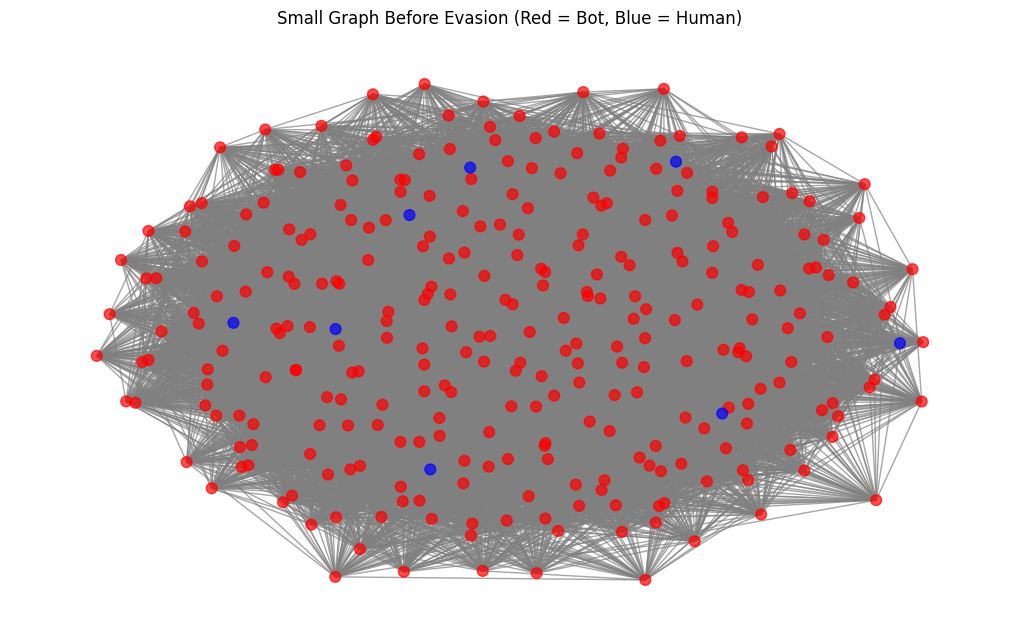

In [13]:
# %%
import matplotlib.pyplot as plt
import networkx as nx
import random

# Choose top users for visualization
top_users = full_df.sort_values("num_keywords", ascending=False).head(300)["Username"].tolist()

# Build small graph (before evasion)
smallG_before = nx.Graph()
smallG_before.add_nodes_from(top_users)

# Build keyword mapping for small graph
small_kw_map = {}
for user in top_users:
    small_kw_map[user] = user_kw_set.get(user, set())

# Connect users if they share at least one keyword
edges = []
for i in range(len(top_users)):
    ui = top_users[i]
    for j in range(i+1, len(top_users)):
        uj = top_users[j]
        if small_kw_map[ui] & small_kw_map[uj]:  # shared keywords
            edges.append((ui, uj))
smallG_before.add_edges_from(edges)

# Colors before evasion
colors_before = ['red' if full_df.loc[full_df["Username"] == u, "Bot Label"].values[0] == 1 else 'blue' 
                 for u in top_users]

# Layout
pos = nx.spring_layout(smallG_before, seed=42)

plt.figure(figsize=(10, 6))
nx.draw(smallG_before, pos, node_size=60, node_color=colors_before, edge_color="gray", alpha=0.7)
plt.title("Small Graph Before Evasion (Red = Bot, Blue = Human)")
plt.show()


## **graph AFTER evasion**

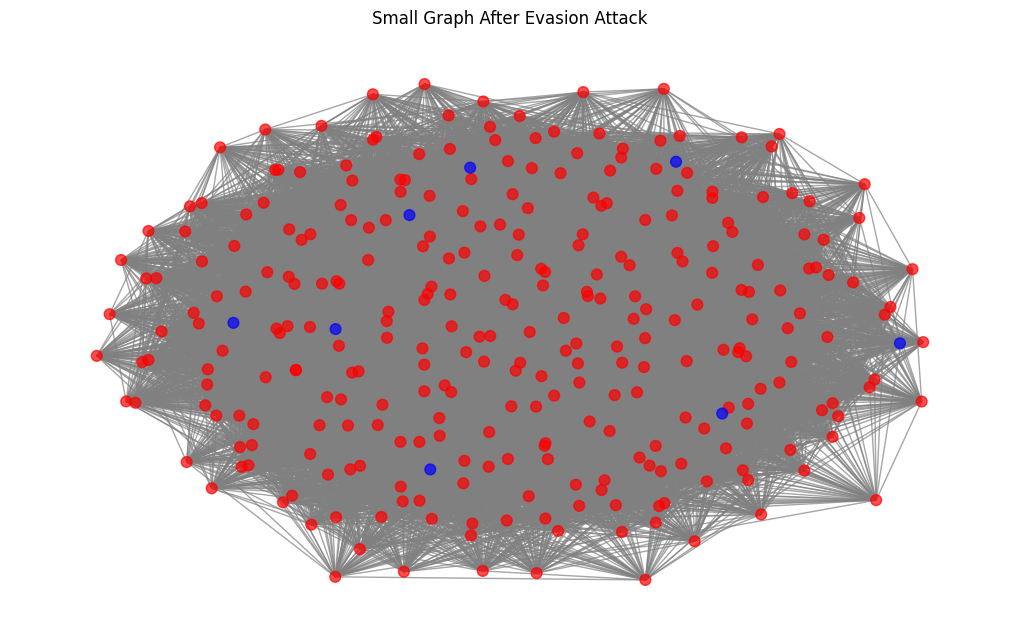

In [14]:
# %%
# Build small graph AFTER evasion attack
small_kw_map_evasion = {}
for user in top_users:
    # Use modified keywords if bot was attacked
    if user in attack_bots:
        small_kw_map_evasion[user] = set(evasion_kw[user])
    else:
        small_kw_map_evasion[user] = user_kw_set.get(user, set())

smallG_after = nx.Graph()
smallG_after.add_nodes_from(top_users)

edges_after = []
for i in range(len(top_users)):
    ui = top_users[i]
    for j in range(i+1, len(top_users)):
        uj = top_users[j]
        if small_kw_map_evasion[ui] & small_kw_map_evasion[uj]:
            edges_after.append((ui, uj))
smallG_after.add_edges_from(edges_after)

colors_after = colors_before  # same labels

plt.figure(figsize=(10, 6))
nx.draw(smallG_after, pos, node_size=60, node_color=colors_after, edge_color="gray", alpha=0.7)
plt.title("Small Graph After Evasion Attack")
plt.show()


## **13.Visualization 2: Confusion Matrix Heatmaps**
We show Baseline, Evasion, and Poisoning confusion matrices as heatmaps.


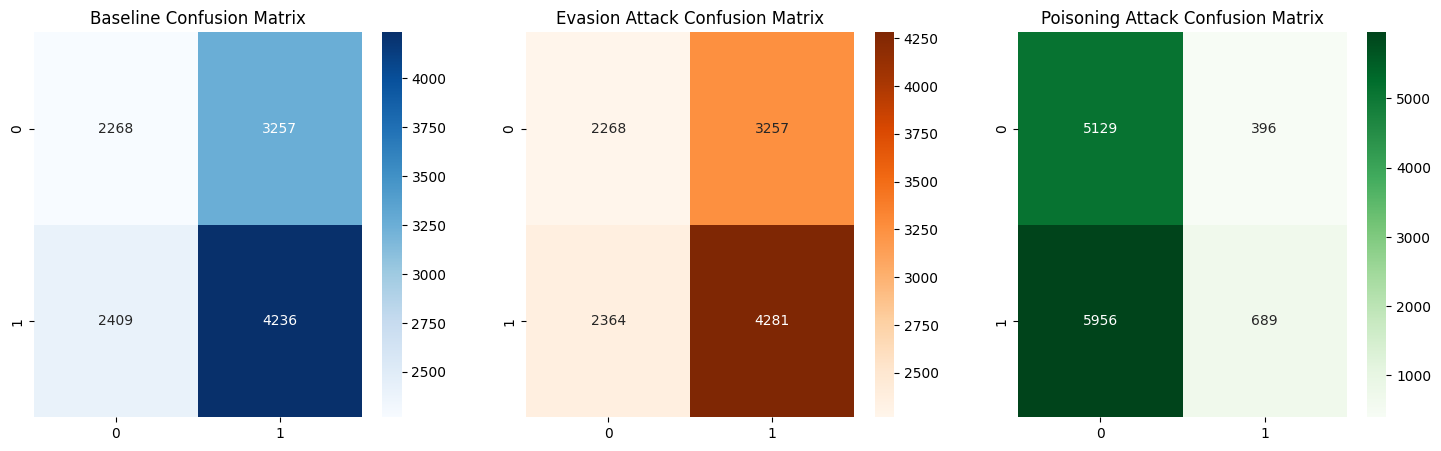

In [15]:
# %%
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Baseline
sns.heatmap(confusion_matrix(y_test, clf.predict(X_test_scaled)), annot=True, fmt="d",
            cmap="Blues", ax=axes[0])
axes[0].set_title("Baseline Confusion Matrix")

# Evasion
sns.heatmap(confusion_matrix(y_test, y_pred_evasion), annot=True, fmt="d",
            cmap="Oranges", ax=axes[1])
axes[1].set_title("Evasion Attack Confusion Matrix")

# Poisoning
sns.heatmap(confusion_matrix(y_test, y_pred_poison), annot=True, fmt="d",
            cmap="Greens", ax=axes[2])
axes[2].set_title("Poisoning Attack Confusion Matrix")

plt.show()


## **14.Visualization 3: Performance Comparison (Baseline vs Evasion vs Poisoning)**

We compare Accuracy and Bot Recall across the three conditions.


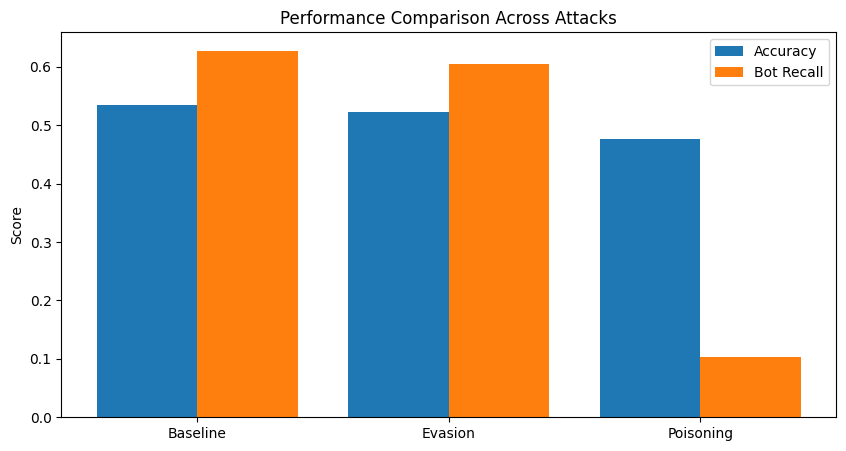

In [16]:
# %%
baseline_accuracy = 0.5343
baseline_bot_recall = 0.6274

evasion_accuracy = 0.5221
evasion_bot_recall = 0.6050

poison_accuracy = 0.4766
poison_bot_recall = 0.1028

labels = ["Baseline", "Evasion", "Poisoning"]
acc_values = [baseline_accuracy, evasion_accuracy, poison_accuracy]
recall_values = [baseline_bot_recall, evasion_bot_recall, poison_bot_recall]

x = range(len(labels))

plt.figure(figsize=(10,5))
plt.bar(x, acc_values, width=0.4, label="Accuracy", align='center')
plt.bar([p+0.4 for p in x], recall_values, width=0.4, label="Bot Recall")
plt.xticks([p+0.2 for p in x], labels)
plt.ylabel("Score")
plt.title("Performance Comparison Across Attacks")
plt.legend()
plt.show()
